# Loading AP articles and categories

 * Check AP categories available in SPT content (elastic search), make sure we are able to retrieve main sections found on http://www.aftenposten.no
 * Make sure we can join AP view events and article categories
 * First descriptive analysis of article (lifetime) and user (consumption distribution) characteristics
 * Look at a first model of user consumption based on categories

In [1]:
import json

content_path = "/Users/gui/Data/ap_article_content_es_no_utf.json"
with open(content_path) as file:
    articles = json.load(file)['hits']['hits']

articles[0]

{u'_id': u'8188176',
 u'_index': u'ap-v1.1',
 u'_score': 0.9570367,
 u'_type': u'article',
 u'fields': {u'categories': [u'okonomi'],
  u'published': [u'2015-10-02T11:47:53.000Z']}}

In [228]:
from itertools import chain
import numpy as np
import pandas as pd

def load_article_categories_df(path="/Users/gui/Data/ap_article_content_es_no_utf.json"):
    with open(content_path) as file:
        articles = json.load(file)['hits']['hits']

    unique_categories = set(chain(*[a['fields']['categories'] for a in articles]))
    vocabulary = {c:i for i, c in enumerate(unique_categories)}

    def to_binary_variables(category):
        return np.asarray(np.in1d(list(unique_categories), category), dtype=int) 

    article_ids = [a['_id'] for a in articles]
    article_categories = np.array(
        [to_binary_variables(a['fields']['categories']) for a in articles]
    )

    article_categories_df = pd.DataFrame(
        index=article_ids, data=article_categories, columns=unique_categories)
    return article_categories_df

article_categories_df = load_article_categories_df()
article_categories_df.shape
article_categories_df.head()

,nyheter,lordag (da),byutvikling,anmeldelser,musikk,eksperter,madsen,lund,debatt,okonomi,...,leder,forsiden,anbefalinger,haugen,onsdag (da),torsdag (da),k-magasinet,fremskrittspartiet,kaffe,blogg
8188176,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
8198524,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
8200641,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
8186447,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
8188828,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


## Number of articles per category

(76, 1)


,Articles
forsiden,947
innenriks,398
verden,226
meninger,202
nyheter,190
osloby,188
kultur,174
fredag (da),149
nye artikler,148
skjul fra sistelister,116


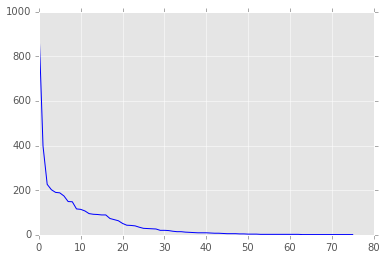

In [233]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

category_counts = pd.DataFrame(
    index=list(unique_categories), 
    data=np.sum(article_categories, axis=0),
columns=["Articles"]).sort_values(by='Articles', ascending=False)

plt.plot(category_counts, 'b-')
print category_counts.shape
category_counts.head(10)

### Focusing on the categories matching top level sections

Suspiciously small number of articles from the sport category ...

In [115]:
main_categories = ['innenriks', 'verden', 'meninger', 'osloby', 'kultur', 'okonomi', 'sport', 'sport inbox']
article_from_main_categories = article_categories_df[main_categories].copy()
article_from_main_categories['sport'] = article_from_main_categories['sport'] + article_from_main_categories['sport inbox']

from_main_cat = np.any(article_from_main_categories.values==1, 1)
article_from_main_categories = article_from_main_categories.ix[from_main_cat, :-1].copy()
category_counts.loc[main_categories]

,Articles
innenriks,398
verden,226
meninger,202
osloby,188
kultur,174
okonomi,92
sport,3
sport inbox,27


# Loading AP user/article view events

In [116]:
events_file = "~/Data/collapsed_events_30_days.csv"
user_events = pd.read_csv(events_file, header=None, names=['ts', 'type', 'user', 'item'], parse_dates=['ts'])

print("{} views from {} x {} user/articles from {} to {}".format(
        user_events.shape[0],
        user_events.user.unique().shape,
        user_events.item.unique().shape,
        user_events.ts.min(),
        user_events.ts.max()))

2389103 views from (149065,) x (38953,) user/articles from 2015-09-15 23:59:54 to 2015-10-15 23:59:36


In [117]:
events_with_article_content = user_events.item.isin(article_from_main_categories.index)
user_events = user_events.ix[events_with_article_content.values,:]

print("{} events with content from {} x {} user/articles".format(
        user_events.shape[0],
        user_events.user.unique().shape,
        user_events.item.unique().shape))
user_events.head()

649358 events with content from (80076,) x (992,) user/articles


,ts,type,user,item
3,2015-10-07 18:56:51,View,3530156,8192364
6,2015-10-08 06:01:03,View,3667067,8191776
8,2015-10-10 10:48:49,View,241534,8191776
11,2015-10-03 13:55:08,View,1138662,8187739
13,2015-10-09 09:48:02,View,3366339,8196238


# Joining article views and categories

In [118]:
user_events_with_cat = pd.merge(
    user_events,
    article_from_main_categories.reset_index(),
    left_on='item',
    right_on='index')
    
user_events_with_cat.head(5)

,ts,type,user,item,index,innenriks,verden,meninger,osloby,kultur,okonomi,sport
0,2015-10-07 18:56:51,View,3530156,8192364,8192364,1,0,0,0,0,0,0
1,2015-10-07 20:29:59,View,4730292,8192364,8192364,1,0,0,0,0,0,0
2,2015-10-07 18:21:15,View,3701590,8192364,8192364,1,0,0,0,0,0,0
3,2015-10-08 06:15:17,View,406649,8192364,8192364,1,0,0,0,0,0,0
4,2015-10-08 20:12:49,View,3821803,8192364,8192364,1,0,0,0,0,0,0


## Views per category

In [120]:
pd.DataFrame(user_events_with_cat[main_categories[:-1]].sum(), columns=['views'])

,views
innenriks,194840
verden,169772
meninger,104564
osloby,105430
kultur,54621
okonomi,83724
sport,245


## Number of views per user

In [119]:
user_category_counts = user_events_with_cat.groupby('user')[main_categories[:-1]].sum()
user_category_counts.head()

,innenriks,verden,meninger,osloby,kultur,okonomi,sport
user,,,,,,,
100013,2,0,2,0,2,2,0
100018,2,3,3,0,2,0,0
100027,1,0,1,0,0,0,0
100044,1,0,0,0,0,0,0
100136,2,2,1,3,1,0,0


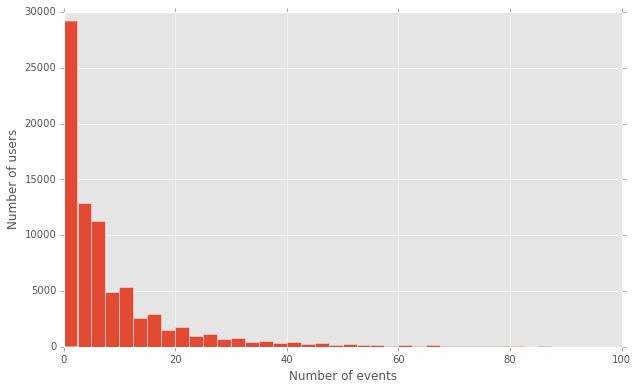

In [121]:
user_totals = user_category_counts.values.sum(1)

plt.figure(figsize=(10, 6))
plt.hist(user_totals, bins=40, range=[0, 100])
plt.xlabel('Number of events')
plt.ylabel('Number of users')
plt.xlim([0, 100]);

In [240]:
np.percentile(user_totals, 80)

13.0

## User as mixture of categories

In [122]:
user_category_probs = pd.DataFrame(
    index=user_category_counts.index,
    data=user_category_counts.values.astype('float') / np.reshape(user_totals, (-1, 1)),
    columns=user_category_counts.columns)

user_category_probs.head()

,innenriks,verden,meninger,osloby,kultur,okonomi,sport
user,,,,,,,
100013,0.250000,0.000000,0.250000,0.000000,0.250000,0.25,0
100018,0.200000,0.300000,0.300000,0.000000,0.200000,0.00,0
100027,0.500000,0.000000,0.500000,0.000000,0.000000,0.00,0
100044,1.000000,0.000000,0.000000,0.000000,0.000000,0.00,0
100136,0.222222,0.222222,0.111111,0.333333,0.111111,0.00,0


## Representing users in the category space

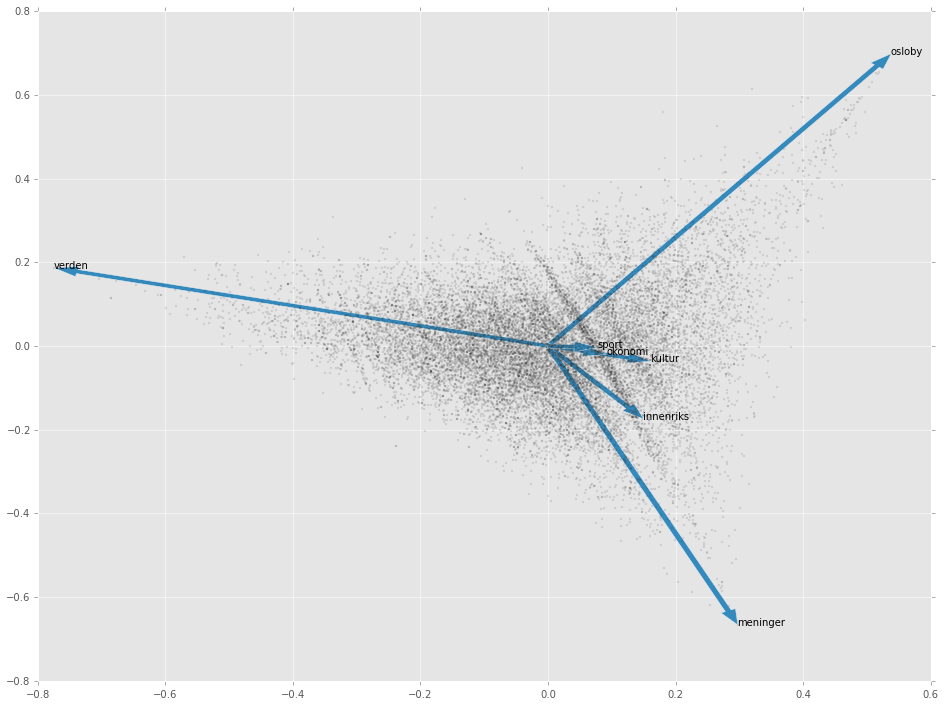

In [225]:
from sklearn.decomposition import PCA

plt.figure(figsize=(16, 12))
pca = PCA(n_components=2)
user_2d = pca.fit_transform(user_category_probs.values[user_totals > 10,:])

plt.plot(user_2d[:,0], user_2d[:,1], 'ko', markeredgecolor='grey', ms=2, alpha=.1)

def categories_to_canonical_array(categories, main_cats=user_category_counts.columns.tolist()):
    return np.array([1 if m in categories else 0 for m in main_cats])

for cat in user_category_counts.columns:
    cat_point = pca.transform(categories_to_canonical_array([cat]))[0]
    plt.text(*cat_point, s=cat)
    plt.arrow(0, 0, cat_point[0], cat_point[1], width=0.01, length_includes_head=True, head_width=0.025)

## Articles lifetime

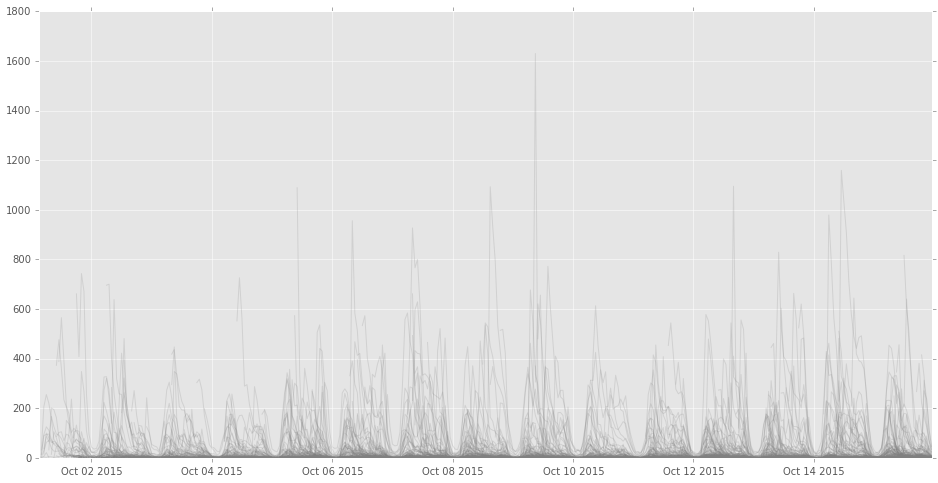

In [132]:
plt.figure(figsize=(16, 8))
user_events.groupby('item')['ts'].apply(lambda x: plot_hourly_counts(x, color='grey', alpha=.2));

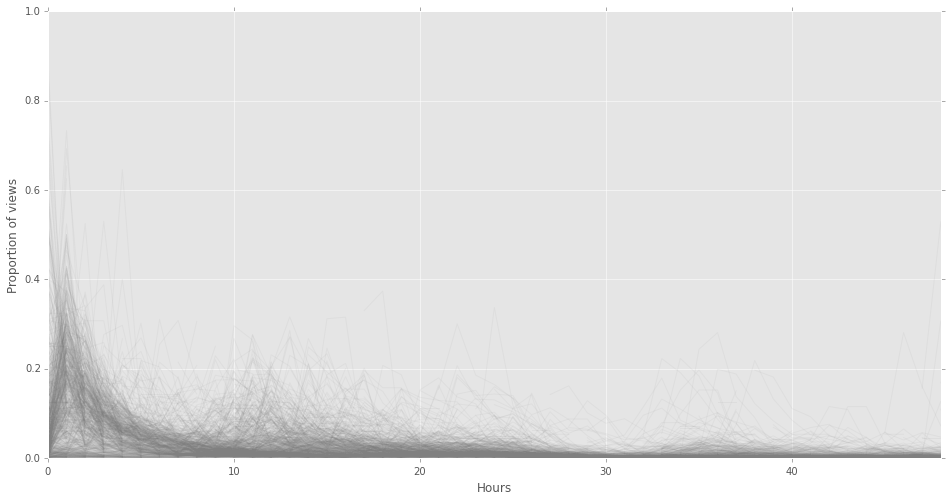

In [241]:
plt.figure(figsize=(16, 8))

def hourly_counts_ts(grouped_user_events_ts, scale=False, relative=False):
    tts = pd.DataFrame(
        index=grouped_user_events_ts.values,
        data=np.ones_like(grouped_user_events_ts.values, dtype='int'),
        columns=['count'])
    hourly_counts = tts.resample('h', how='sum')
    times = (hourly_counts.index - hourly_counts.index.min()).total_seconds() / 3600 if relative else hourly_counts.index 
    counts = hourly_counts.values / len(grouped_user_events_ts) if scale else hourly_counts.values 

    return pd.DataFrame(index=times, data=counts.ravel(), columns=['count'])

def plot_hourly_counts(grouped_user_events_ts, scale=False, relative=False, **kwargs):
    hourly_counts = hourly_counts_ts(grouped_user_events_ts, scale, relative)
    plt.plot(hourly_counts.index, hourly_counts.values, **kwargs)
    
#plot_hourly_counts(user_events[user_events.item == '8192364']['ts'], relative=False, scale=False, color='blue')

user_events.groupby('item')['ts'].apply(lambda x: plot_hourly_counts(x, scale=True, relative=True, color='grey', alpha=.07))
plt.xlabel('Hours')
plt.ylabel('Proportion of views')
plt.xlim([0, 48]);

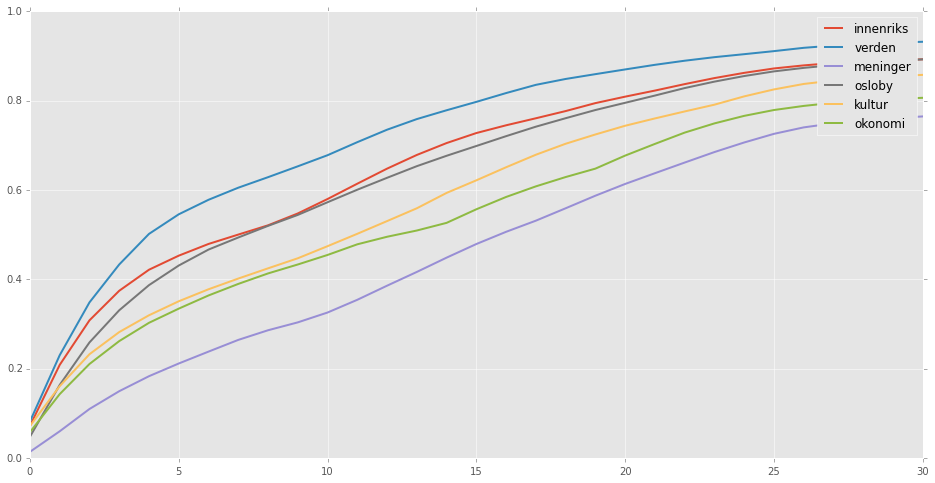

In [136]:
articles_hourly_counts = user_events.groupby('item')['ts'].apply(lambda x : hourly_counts_ts(x, relative=True))

hourly_counts_with_cat = pd.merge(
    articles_hourly_counts.reset_index(),
    article_categories_df[main_categories[:-2]].reset_index(),
    right_on='index',left_on='item')

hourly_counts_with_cat.head()

plt.figure(figsize=(16, 8))

for c in main_categories[:-2]:
    counts = hourly_counts_with_cat[hourly_counts_with_cat[c] == 1].groupby('level_1')['count'].sum()
    plt.plot(counts.cumsum() / counts.sum(), label=c, lw=2)
    
plt.xlim([0, 30])
plt.legend();